In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import arviz as az
import pickle
import os
import seaborn as sns
import arviz.labels as azl
import matplotlib.colors as mcolors
from scipy import stats
from tqdm.notebook import tqdm
from FlYMazeRL.agents.classical import *
from FlYMazeRL.gym.environment import ymaze_baiting,ymaze_static,ymaze_dynamic
from FlYMazeRL.utils import generate_params_from_fits,get_schedule_histories
from FlYMazeRL.utils.visualization import draw_schedule
from FlYMazeRL.utils.generators import generate_params_from_fits, generate_random_schedule_with_blocks
from FlYMazeRL.utils.evaluation import get_schedule_histories, get_schedule_fitness


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
model_name_map = {
    'HCQBR': 'Long-Term Habit-Value Arbiter Q-Learning',
    'HQBR': 'Immediate Habit-Value Arbiter Q-Learning',
    'FHQBR': 'Forgetting Immediate Habit-Value Arbiter Q-Learning',
    'FHCQBR': 'Forgetting Long-Term Habit-Value Arbiter Q-Learning',
    'OSCQBR': 'Long-Term Omission-Sensitive Q-Learning',
    'OSQBR': 'Immediate Omission-Sensitive Q-Learning',
    'FOSCQBR': 'Forgetting Long-Term Omission-Sensitive Q-Learning',
    'FOSQBR': 'Forgetting Immediate Omission-Sensitive Q-Learning',
    'DFOSCQBR': 'Differential Forgetting Long-Term Omission-Sensitive Q-Learning',
    'DFOSQBR': 'Differential Forgetting Immediate Omission-Sensitive Q-Learning',
    'DFCQBR': 'Differential Forgetting Long-Term Q-Learning',
    'DFQBR': 'Differential Forgetting Immediate Q-Learning',
    'DECQBR': 'Differential Extinction Long-Term Q-Learning',
    'DEQBR': 'Differential Extinction Immediate Q-Learning',
    'FCQBR': 'Forgetting Long-Term Q-Learning',
    'FQBR': 'Forgetting Immediate Q-Learning',
    'CQBR': 'Long-Term Q-Learning',
    'SBR': 'SARSA',
    'ESBR': 'Expected SARSA',
    'IQBR': 'Immediate Q-Learning',
    'RBR': 'RPE-free Q-Learning',
    'FRBR': 'Forgetting RPE-free Q-Learning',
}

model_simple_abv_map = {
    'HCQBR': 'LT-HV-QL',
    'HQBR': 'I-HV-QL',
    'FHQBR': 'F-I-HV-QL',
    'FHCQBR': 'F-LT-HV-QL',
    'DFOSCQBR': 'DF-LT-OS-QL',
    'DFOSQBR': 'DF-I-OS-QL',
    'FOSCQBR': 'F-LT-OS-QL',
    'FOSQBR': 'F-I-OS-QL',
    'OSCQBR': 'LT-OS-QL',
    'OSQBR': 'I-OS-QL',
    'DECQBR': 'DE-LT-QL',
    'DEQBR': 'DE-I-QL',
    'DFCQBR': 'DF-LT-QL',
    'DFQBR': 'DF-I-QL',
    'FCQBR': 'F-LT-QL',
    'FQBR': 'F-I-QL',
    'CQBR': 'LT-QL',
    'SBR': 'SARSA',
    'ESBR': 'ESARSA',
    'IQBR': 'I-QL',
    'RBR': 'RF-QL',
    'FRBR': 'F-RF-QL',
    }

model_class_name_map = {
    'HCQLearner_banditreject': 'HCQBR',
    'HQLearner_banditreject': 'HQBR',
    'FHCQLearner_banditreject': 'FHCQBR',
    'FHQLearner_banditreject': 'FHQBR',
    'OSCQLearner_banditreject': 'OSCQBR',
    'OSQLearner_banditreject': 'OSQBR',
    'FOSCQLearner_banditreject': 'FOSCQBR',
    'FOSQLearner_banditreject': 'FOSQBR',
    'DFOSCQLearner_banditreject': 'DFOSCQBR',
    'DFOSQLearner_banditreject': 'DFOSQBR',
    'DFCQLearner_banditreject': 'DFCQBR',
    'DFQLearner_banditreject': 'DFQBR',
    'DECQLearner_banditreject': 'DECQBR',
    'DEQLearner_banditreject': 'DEQBR',
    'FCQLearner_banditreject': 'FCQBR',
    'FQLearner_banditreject': 'FQBR',
    'CQLearner_banditreject': 'CQBR',
    'IQLearner_banditreject': 'IQBR',
    'SARSALearner_banditreject': 'SBR',
    'ESARSALearner_banditreject': 'ESBR',
    'RewardLearner_banditreject': 'RBR',
    'ForgettingRewardLearner_banditreject': 'FRBR',
}
model_database = pd.read_csv("FlYMazeRL/model_description.csv")

### Metadata Verification

In [3]:
def metadata_verify(model):
    metadata = []
    for sample in list(filter(lambda v: "best_schedule" in v,os.listdir(f"FlYMazeRL/optimized_schedules/BR/{model}"))):
        log = list(filter(lambda v: sample.split('_best')[0] in v and '.log' in v,os.listdir(f"FlYMazeRL/optimized_schedules/BR/{model}")))
        if len(log) == 0:
            continue
        with open(f"FlYMazeRL/optimized_schedules/{model}/"+log[0],"rb") as f:
            temp = f.readlines()
            optmeth = str(temp[23])[2:-5].split(': ')[1]
            init = str(temp[26])[2:-5].split(': ')[1]
            metadata.append(f"{optmeth}, {init}")

    for i,j in zip(*np.unique(metadata,return_counts=True)):
        print(f"{i}: {j}")

In [4]:
for model in filter(lambda v:'.' not in v,os.listdir("FlYMazeRL/optimized_schedules/BR")):
    print(model)
    metadata_verify(model)

CQBR
DFCQBR
DFOSCQBR
RBR


DFOSCQBR


  0%|          | 0/39 [00:00<?, ?it/s]

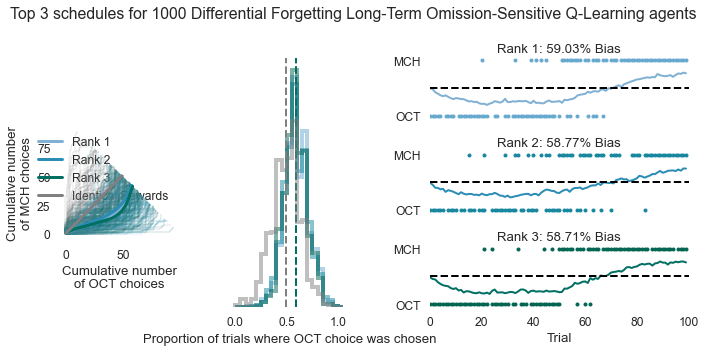

In [7]:
for model in list(filter(lambda v:'.' not in v,os.listdir("FlYMazeRL/optimized_schedules/BR/")))[2:3]:
    print(model)
    model_name = model_name_map[model]
    best_schedules = list(filter(lambda v: "best_schedule" in v,os.listdir(f"FlYMazeRL/optimized_schedules/BR/{model}")))
    best_schedules = [str(f"FlYMazeRL/optimized_schedules/BR/{model}/"+x) for x in best_schedules]

    fitnesses = []
    fitness_distributions = []
    n_agents = 1000
    agentClass = eval(model_database.loc[model_database.SHORTCODE == model, "AgentClass"].values[0])
    params, policy_params = generate_params_from_fits(agentClass, n_agents)

    for schedule_dir in tqdm(best_schedules):
        with open(schedule_dir, "rb") as f:
            schedule = pickle.load(f)
        env = ymaze_static(n_trials_per_session=len(schedule), schedule=schedule)
        action_histories = get_schedule_histories(env, agentClass, n_agents, params, policy_params)
        fitnesses.append((np.array(action_histories)==0).mean())
        fitness_distributions.append((np.array(action_histories)==0).mean(axis=1))

    # Top 3 best schedules
    top3indices = np.argsort(fitnesses)[-3:][::-1]
    top3schedules = [best_schedules[i] for i in top3indices]
    top3fitnesses = [fitnesses[i] for i in top3indices]
    top3distributions = [fitness_distributions[i] for i in top3indices]

    naive_priming_schedule = generate_random_schedule_with_blocks(100, [1,0], [0,1])
    no_preference_schedule = generate_random_schedule_with_blocks(100, [1,0]*50, [1,0]*50)

    import seaborn as sns
    sns.set(style="ticks")
    sns.set(font_scale=1.1)
    plt.figure(figsize=(10,5))
    # Plot the top 3 schedules
    plt.subplot(1,4,1)

    n_agents = 1000
    hists = []
    schedules = []
    rank = 1
    for i,j in zip(top3schedules,[0.5,0.7,0.9]):
        with open(i, "rb") as f:
            schedule = pickle.load(f)
        env = ymaze_static(n_trials_per_session=len(schedule), schedule=schedule)
        histories = get_schedule_histories(env, agentClass, n_agents, params[:n_agents], policy_params[:n_agents])
        histories = np.array(histories)
        
        schedules.append(np.array(schedule))
        hists.append(histories)
        
        for n in range(n_agents//10):
            plt.plot(np.cumsum(histories[n]==0),np.cumsum(histories[n]==1),'-',color=plt.cm.PuBuGn(j),alpha=1,zorder=np.random.randint(0,n_agents),linewidth=0.2)
        plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color=plt.cm.PuBuGn(j-0.05),zorder=n_agents+1,label=f"Rank {rank}")
        rank += 1

    env = ymaze_static(n_trials_per_session=len(schedule), schedule=no_preference_schedule)
    histories = get_schedule_histories(env, agentClass, n_agents, params[:n_agents], policy_params[:n_agents])
    histories = np.array(histories)
    for n in range(n_agents//10):
        plt.plot(np.cumsum(histories[n]==0),np.cumsum(histories[n]==1),'-',color='gray',alpha=1,zorder=np.random.randint(0,n_agents),linewidth=0.2)
    plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color='gray',zorder=n_agents+1,label=f"Identical Rewards")

    plt.plot([0,len(schedule)//2],[0,len(schedule)//2],linewidth=2,color='black',linestyle='--')
    plt.xlabel('Cumulative number\nof OCT choices')
    plt.ylabel('Cumulative number\nof MCH choices')
    plt.box(False)
    plt.legend(loc='upper right',frameon=False)
    plt.gca().set_aspect('equal')

    plt.subplot(1,4,2)
    for i,j in zip(top3distributions,[0.5,0.7,0.9]):
        plt.hist(i,bins=np.arange(0,1.1,0.05),color=plt.cm.PuBuGn(j),alpha=0.5,density=True,histtype='step',linewidth=4)
        plt.axvline(i.mean(),linewidth=2,color=plt.cm.PuBuGn(j-0.05),linestyle='--')
    plt.hist((histories==0).mean(axis=1),bins=np.arange(0,1.1,0.05),color='gray',alpha=0.5,density=True,histtype='step',linewidth=4)
    plt.axvline((histories==0).mean(),linewidth=2,color='gray',linestyle='--')
    plt.yticks([])
    plt.xlabel('Proportion of trials where OCT choice was chosen')
    plt.box(False)

    rank = 1
    for i,h,j,p in zip(schedules,hists,[0.5,0.7,0.9],[2,4,6]):
        plt.subplot(3,2,p)
        plt.plot(np.arange(i.shape[0])[i[:,0]==1],np.zeros(np.sum(i[:,0]==1)),'.',color=plt.cm.PuBuGn(j),linewidth=2)
        plt.plot(np.arange(i.shape[0])[i[:,1]==1],np.ones(np.sum(i[:,1]==1)),'.',color=plt.cm.PuBuGn(j),linewidth=2)
        plt.plot(h.mean(axis=0),'-',color=plt.cm.PuBuGn(j-0.05),linewidth=2)
        plt.yticks([0,1],["OCT","MCH"])
        plt.xlim([0,i.shape[0]])
        plt.axhline(0.5,linewidth=2,color='black',linestyle='--')
        plt.title(f"Rank {rank}: {top3fitnesses[rank-1]*100:.2f}% Bias")
        plt.box(False)
        if p==6:
            plt.xlabel('Trial')
        else:
            plt.xticks([])
        rank += 1

    plt.suptitle('Top 3 schedules for {} {} agents'.format(n_agents,model_name))
    plt.tight_layout()
    plt.savefig('top3_schedules_'+model_name+'.svg',transparent=True)
    plt.show()

CQBR


  0%|          | 0/10 [00:00<?, ?it/s]

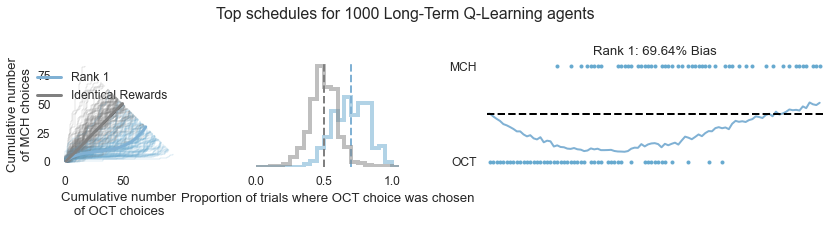

DFCQBR


  0%|          | 0/20 [00:00<?, ?it/s]

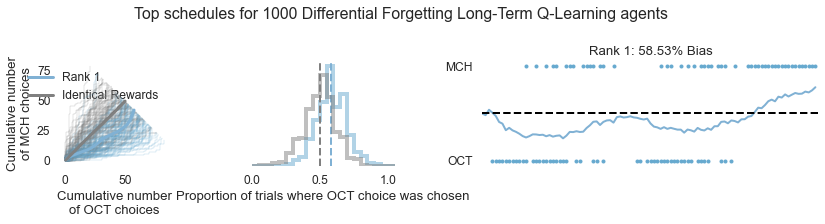

DFOSCQBR


  0%|          | 0/39 [00:00<?, ?it/s]

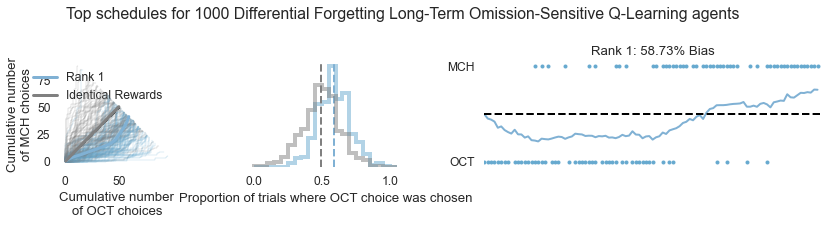

RBR


  0%|          | 0/40 [00:00<?, ?it/s]

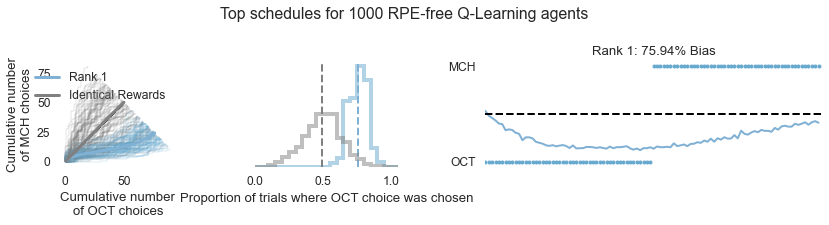

In [6]:
for model in list(filter(lambda v:'.' not in v,os.listdir("FlYMazeRL/optimized_schedules/BR/"))):
    print(model)
    model_name = model_name_map[model]
    best_schedules = list(filter(lambda v: "best_schedule" in v,os.listdir(f"FlYMazeRL/optimized_schedules/BR/{model}")))
    best_schedules = [str(f"FlYMazeRL/optimized_schedules/BR/{model}/"+x) for x in best_schedules]

    fitnesses = []
    fitness_distributions = []
    n_agents = 1000
    agentClass = eval(model_database.loc[model_database.SHORTCODE == model, "AgentClass"].values[0])
    params, policy_params = generate_params_from_fits(agentClass, n_agents)

    for schedule_dir in tqdm(best_schedules):
        with open(schedule_dir, "rb") as f:
            schedule = pickle.load(f)
        env = ymaze_static(n_trials_per_session=len(schedule), schedule=schedule)
        action_histories = get_schedule_histories(env, agentClass, n_agents, params, policy_params)
        fitnesses.append((np.array(action_histories)==0).mean())
        fitness_distributions.append((np.array(action_histories)==0).mean(axis=1))

    # Best schedule
    topindices = np.argsort(fitnesses)[-1:][::-1]
    topschedules = [best_schedules[i] for i in topindices]
    topfitnesses = [fitnesses[i] for i in topindices]
    topdistributions = [fitness_distributions[i] for i in topindices]

    naive_priming_schedule = generate_random_schedule_with_blocks(100, [1,0], [0,1])
    no_preference_schedule = generate_random_schedule_with_blocks(100, [1,0]*50, [1,0]*50)

    import seaborn as sns
    sns.set(style="ticks")
    sns.set(font_scale=1.1)
    plt.figure(figsize=(12,3))
    # Plot the top 3 schedules
    plt.subplot(1,4,1)

    n_agents = 1000
    hists = []
    schedules = []
    rank = 1
    for i,j in zip(topschedules,[0.5]):
        with open(i, "rb") as f:
            schedule = pickle.load(f)
        env = ymaze_static(n_trials_per_session=len(schedule), schedule=schedule)
        histories = get_schedule_histories(env, agentClass, n_agents, params[:n_agents], policy_params[:n_agents])
        histories = np.array(histories)
        
        schedules.append(np.array(schedule))
        hists.append(histories)
        
        for n in range(n_agents//10):
            plt.plot(np.cumsum(histories[n]==0),np.cumsum(histories[n]==1),'-',color=plt.cm.PuBuGn(j),alpha=1,zorder=np.random.randint(0,n_agents),linewidth=0.2)
        plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color=plt.cm.PuBuGn(j-0.05),zorder=n_agents+1,label=f"Rank {rank}")
        rank += 1

    env = ymaze_static(n_trials_per_session=len(schedule), schedule=no_preference_schedule)
    histories = get_schedule_histories(env, agentClass, n_agents, params[:n_agents], policy_params[:n_agents])
    histories = np.array(histories)
    for n in range(n_agents//10):
        plt.plot(np.cumsum(histories[n]==0),np.cumsum(histories[n]==1),'-',color='gray',alpha=1,zorder=np.random.randint(0,n_agents),linewidth=0.2)
    plt.plot(np.cumsum(histories==0,axis=1).mean(axis=0),np.cumsum(histories==1,axis=1).mean(axis=0),linewidth=3,color='gray',zorder=n_agents+1,label=f"Identical Rewards")

    plt.plot([0,len(schedule)//2],[0,len(schedule)//2],linewidth=2,color='black',linestyle='--')
    plt.xlabel('Cumulative number\nof OCT choices')
    plt.ylabel('Cumulative number\nof MCH choices')
    plt.box(False)
    plt.legend(loc='upper right',frameon=False)
    plt.gca().set_aspect('equal')

    plt.subplot(1,4,2)
    for i,j in zip(topdistributions,[0.5]):
        plt.hist(i,bins=np.arange(0,1.1,0.05),color=plt.cm.PuBuGn(j),alpha=0.5,density=True,histtype='step',linewidth=4)
        plt.axvline(i.mean(),linewidth=2,color=plt.cm.PuBuGn(j-0.05),linestyle='--')
    plt.hist((histories==0).mean(axis=1),bins=np.arange(0,1.1,0.05),color='gray',alpha=0.5,density=True,histtype='step',linewidth=4)
    plt.axvline((histories==0).mean(),linewidth=2,color='gray',linestyle='--')
    plt.yticks([])
    plt.xlabel('Proportion of trials where OCT choice was chosen')
    plt.box(False)

    rank = 1
    for i,h,j,p in zip(schedules,hists,[0.5],[2]):
        plt.subplot(1,2,p)
        plt.plot(np.arange(i.shape[0])[i[:,0]==1],np.zeros(np.sum(i[:,0]==1)),'.',color=plt.cm.PuBuGn(j),linewidth=2)
        plt.plot(np.arange(i.shape[0])[i[:,1]==1],np.ones(np.sum(i[:,1]==1)),'.',color=plt.cm.PuBuGn(j),linewidth=2)
        plt.plot(h.mean(axis=0),'-',color=plt.cm.PuBuGn(j-0.05),linewidth=2)
        plt.yticks([0,1],["OCT","MCH"])
        plt.xlim([0,i.shape[0]])
        plt.axhline(0.5,linewidth=2,color='black',linestyle='--')
        plt.title(f"Rank {rank}: {topfitnesses[rank-1]*100:.2f}% Bias")
        plt.box(False)
        if p==6:
            plt.xlabel('Trial')
        else:
            plt.xticks([])
        rank += 1

    plt.suptitle('Top schedules for {} {} agents'.format(n_agents,model_name))
    plt.tight_layout()
    plt.savefig('top_schedules_'+model_name+'.svg',transparent=True)
    plt.show()